In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Задание

В файлах *iCafe 2 month.xlsx* и *iCafe 15 days.xlsx* содержатся данные для обучения и тестирования классификаторов. Требуется построить три классификатора:

- На основе логистической регрессии;
- На основе дерева решений;
- На основе метода ближайшего соседа.

Основная цель - это достичь значение $F_1$ метрики на выборке 15 дней не менее чем:
- 0.86 для логистической регрессии;
- 0.9 для дерева решений;
- 0.89 для метода ближайшего соседа.

Вам будут даны небольшие подсказки в виде преобразования данных, но основные действия по преобразованию и выбору
признаков для обучения остаются за вами.

Так же, необходимо провести анализ и сделать выводы о результатах, при изменении параметров:
- ***max_depth***, при обучении дерева решений;
- ***n_neighbors***, при обучении классификатора методом ближайшего соседа.

Опишите эти выводы текстом в блокноте с решением. При каких значениях гиперпараметров модели становятся максимально переобученными? Какова область значений гиперпараметров, в которой они могут повлиять на качество обучения модели?

----

### Поиск параметров, влияющих на классификацию

In [2]:
import pandas as pd

df_train = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/d03/iCafe 2 month.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/d03/iCafe 15 days.xlsx')

In [3]:
df_train

Order_date_time  Delivery_time  Office  Rain
0       2020-09-01 0:15:10             10       1     1
1       2020-09-01 0:17:38              5       1     1
2       2020-09-01 0:20:23             17       1     1
3       2020-09-01 0:29:52             12       0     1
4       2020-09-01 0:32:52              9       1     1
...                    ...            ...     ...   ...
20786  2020-10-31 23:28:08              4       1     1
20787  2020-10-31 23:39:56             10       1     1
20788  2020-10-31 23:43:11              9       1     1
20789  2020-10-31 23:47:56              9       1     1
20790  2020-10-31 23:48:52              5       1     1

[20791 rows x 4 columns]

In [4]:
df_test

Order_date_time  Delivery_time  Office  Rain
0      2020-11-01 0:02:37              3       1   0.0
1      2020-11-01 0:09:50             15       0   0.0
2      2020-11-01 0:10:35              7       1   0.0
3      2020-11-01 0:13:08              8       1   0.0
4      2020-11-01 0:22:38              7       1   0.0
...                   ...            ...     ...   ...
5468  2020-11-15 23:36:56              6       1   NaN
5469  2020-11-15 23:43:57              8       1   NaN
5470  2020-11-15 23:45:35              6       1   NaN
5471  2020-11-15 23:49:25              3       1   NaN
5472  2020-11-15 23:56:46              6       1   NaN

[5473 rows x 4 columns]

In [5]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20791 entries, 0 to 20790
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Order_date_time  20791 non-null  object
 1   Delivery_time    20791 non-null  int64 
 2   Office           20791 non-null  int64 
 3   Rain             20791 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 649.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_date_time  5473 non-null   object 
 1   Delivery_time    5473 non-null   int64  
 2   Office           5473 non-null   int64  
 3   Rain             4516 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 171.2+ KB


In [6]:
from datetime import datetime

def get_necessary_info (series_row):
  date, time = (series_row['Order_date_time']).split()
  time_sec = int(pd.to_timedelta(time).total_seconds())
  temp = datetime.strptime(series_row['Order_date_time'], '%Y-%m-%d %H:%M:%S')
  year = temp.year
  month = temp.month
  day = temp.day
  hour = temp.hour
  week_num_year, day_of_the_week = temp.isocalendar()[1: 3]
  week_num_month = (day + (7 - day_of_the_week)) // 7
  time_sec_delta = (time_sec + 6000) % 86400
  res = pd.Series([series_row['Order_date_time'], series_row['Delivery_time'], series_row['Office'], series_row['Rain'], date, time,
                   day_of_the_week, time_sec, year, month, day, hour, week_num_year, week_num_month, time_sec_delta])
  return res

def fill_df(df):
  df = pd.DataFrame([get_necessary_info(df.loc[i]) for i in df.index])
  df.rename(columns={0 : 'Order_date_time',
                     1 : 'Delivery_time',
                     2 : 'Office',
                     3 : 'Rain',
                     4 : 'Order_date',
                     5 : 'Order_time',
                     6 : 'day_of_the_week',
                     7 : 'Order_time_sec',
                     8 : 'Order_year',
                     9 : 'Order_month',
                     10 : 'Order_day',
                     11 : 'Order_hour',
                     12 : 'Order_week_num_year',
                     13 : 'Order_week_num_month',
                     14 : 'Order_time_sec_delta'}, inplace = True)
  return df


df_train = fill_df(df_train)
df_test = fill_df(df_test)
df_train

Order_date_time  Delivery_time  Office  Rain  Order_date  \
0       2020-09-01 0:15:10             10       1     1  2020-09-01   
1       2020-09-01 0:17:38              5       1     1  2020-09-01   
2       2020-09-01 0:20:23             17       1     1  2020-09-01   
3       2020-09-01 0:29:52             12       0     1  2020-09-01   
4       2020-09-01 0:32:52              9       1     1  2020-09-01   
...                    ...            ...     ...   ...         ...   
20786  2020-10-31 23:28:08              4       1     1  2020-10-31   
20787  2020-10-31 23:39:56             10       1     1  2020-10-31   
20788  2020-10-31 23:43:11              9       1     1  2020-10-31   
20789  2020-10-31 23:47:56              9       1     1  2020-10-31   
20790  2020-10-31 23:48:52              5       1     1  2020-10-31   

      Order_time  day_of_the_week  Order_time_sec  Order_year  Order_month  \
0        0:15:10                2             910        2020            9   
1        0:17:38                2            1058        2020            9   
2        0:20:23                2            1223        2020            9   
3        0:29:52                2            1792        2020            9   
4        0:32:52                2            1972        2020            9   
...          ...              ...             ...         ...          ...   
20786   23:28:08                6           84488        2020           10   
20787   23:39:56                6           85196        2020           10   
20788   23:43:11                6           85391        2020           10   
20789   23:47:56                6           85676        2020           10   
20790   23:48:52                6           85732        2020           10   

       Order_day  Order_hour  Order_week_num_year  Order_week_num_month  \
0              1           0                   36                     0   
1              1           0                   36                     0   
2              1           0                   36                     0   
3              1           0                   36                     0   
4              1           0                   36                     0   
...          ...         ...                  ...                   ...   
20786         31          23                   44                     4   
20787         31          23                   44                     4   
20788         31          23                   44                     4   
20789         31          23                   44                     4   
20790         31          23                   44                     4   

       Order_time_sec_delta  
0                      6910  
1                      7058  
2                      7223  
3                      7792  
4                      7972  
...                     ...  
20786                  4088  
20787                  4796  
20788                  4991  
20789                  5276  
20790                  5332  

[20791 rows x 15 columns]

In [7]:
df_train.describe()

Delivery_time        Office          Rain  day_of_the_week  \
count   20791.000000  20791.000000  20791.000000     20791.000000   
mean        8.283440      0.548410      0.398730         3.680872   
std         3.372459      0.497663      0.489649         1.834987   
min         2.000000      0.000000      0.000000         1.000000   
25%         6.000000      0.000000      0.000000         2.000000   
50%         8.000000      1.000000      0.000000         4.000000   
75%        10.000000      1.000000      1.000000         5.000000   
max        19.000000      1.000000      1.000000         7.000000   

       Order_time_sec  Order_year   Order_month     Order_day    Order_hour  \
count    20791.000000     20791.0  20791.000000  20791.000000  20791.000000   
mean     51790.927613      2020.0      9.510894     15.852003     13.885624   
std      19511.018745         0.0      0.499893      9.018616      5.413014   
min          6.000000      2020.0      9.000000      1.000000      0.000000   
25%      41833.500000      2020.0      9.000000      8.000000     11.000000   
50%      46638.000000      2020.0     10.000000     16.000000     12.000000   
75%      69497.500000      2020.0     10.000000     24.000000     19.000000   
max      86393.000000      2020.0     10.000000     31.000000     23.000000   

       Order_week_num_year  Order_week_num_month  Order_time_sec_delta  
count         20791.000000          20791.000000          20791.000000  
mean             40.071137              2.027560          55002.490308  
std               2.534360              1.325359          20819.783690  
min              36.000000              0.000000             22.000000  
25%              38.000000              1.000000          47247.000000  
50%              40.000000              2.000000          52036.000000  
75%              42.000000              3.000000          74709.000000  
max              44.000000              4.000000          86368.000000

In [8]:
df_test.describe()

Delivery_time       Office         Rain  day_of_the_week  \
count    5473.000000  5473.000000  4516.000000      5473.000000   
mean        8.516353     0.494427     0.679362         3.730678   
std         3.330338     0.500015     0.466773         2.007343   
min         2.000000     0.000000     0.000000         1.000000   
25%         6.000000     0.000000     0.000000         2.000000   
50%         8.000000     0.000000     1.000000         3.000000   
75%        11.000000     1.000000     1.000000         5.000000   
max        19.000000     1.000000     1.000000         7.000000   

       Order_time_sec  Order_year  Order_month    Order_day   Order_hour  \
count     5473.000000      5473.0       5473.0  5473.000000  5473.000000   
mean     53196.000000      2020.0         11.0     8.091906    14.277910   
std      19056.973021         0.0          0.0     4.188818     5.282244   
min          1.000000      2020.0         11.0     1.000000     0.000000   
25%      42161.000000      2020.0         11.0     4.000000    11.000000   
50%      48552.000000      2020.0         11.0     9.000000    13.000000   
75%      69985.000000      2020.0         11.0    12.000000    19.000000   
max      86292.000000      2020.0         11.0    15.000000    23.000000   

       Order_week_num_year  Order_week_num_month  Order_time_sec_delta  
count          5473.000000           5473.000000           5473.000000  
mean             45.480175              1.480175          56464.920153  
std               0.560991              0.560991          20558.867916  
min              44.000000              0.000000             30.000000  
25%              45.000000              1.000000          47513.000000  
50%              46.000000              2.000000          52663.000000  
75%              46.000000              2.000000          75243.000000  
max              46.000000              2.000000          86349.000000

Из полученных данных видно, что поставленная задача относится к задачам предсказания. Обучающий набор сформирован на данных за сентябрь-октябрь 2020 года, тестовый набор - на данных за ноябрь того же года. Соответственно, столбцы указывающие на порядок недели в году и год не несут полезной информации. Мы можем получить распределения данных по месяцу, по неделе и по дню - обнаружив зависимости сможем применить их для предсказания значений в пределах следующего месяца.

Столбцы со строковой информацией о времени и дате заказа также не могут быть должным образом обработаны и проанализированы, поэтому будем пользоваться столбцами-эквивалентами в числовом формате

Начнем выявлять зависимости. Предположим, что соотношение заказов на дом и в офис меняется от начала месяца к концу. У нас в распоряжении два месяца - сентябрь и октябрь. На них мы можем подтвердить или опровергнуть эту гипотезу

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


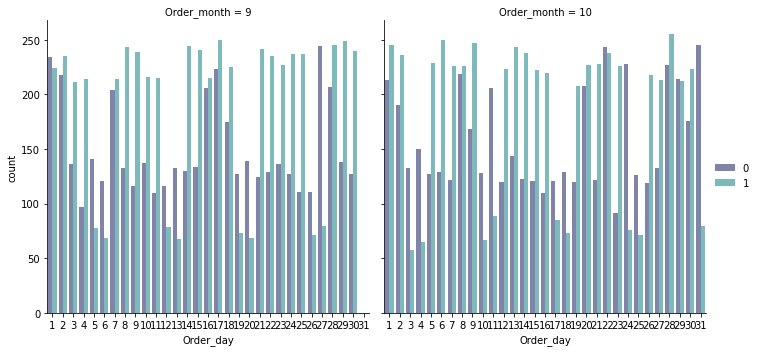

In [9]:
import seaborn as sns

plots = sns.FacetGrid(df_train, col='Order_month', height=5)
plots.map(sns.countplot, 'Order_day', hue=df_train['Office'], palette='mako', alpha=0.7)
plots.add_legend()

На данные слишком сильно влияет распределение соотношения заказов на дом и в офис по дням недели. Для подтверждения гипотезы о функциональной зависимости между соотношением заказов и днем месяца построим графики отдельно для каждого дня недели

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


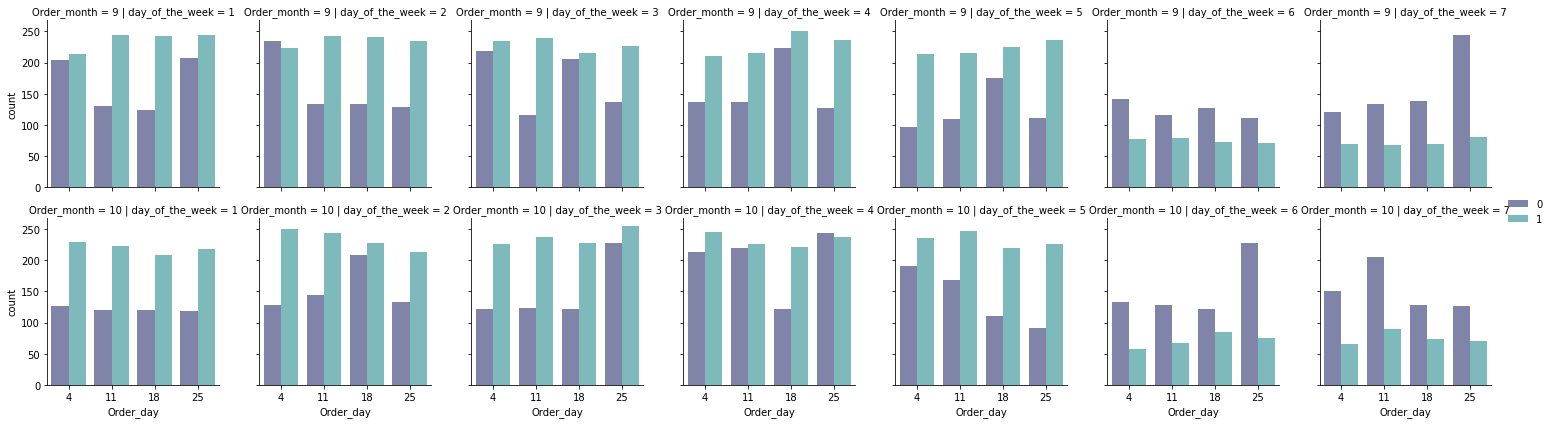

In [ ]:
plots = sns.FacetGrid(df_train, row='Order_month', col='day_of_the_week', height=3)
plots.map(sns.countplot, 'Order_day', hue=df_train['Office'], palette='mako', alpha=0.7)
plots.add_legend()

Мало того, что соотношение для одних дней недели к концу месяца падает, а для других растет, данные в разные месяцы очень сильно отличаются. Это свидетельствует об отсутствии зависимости соотношения заказов на дом и в офис от дня месяца (от того, в начале месяца сделан заказ, в середине или в конце)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


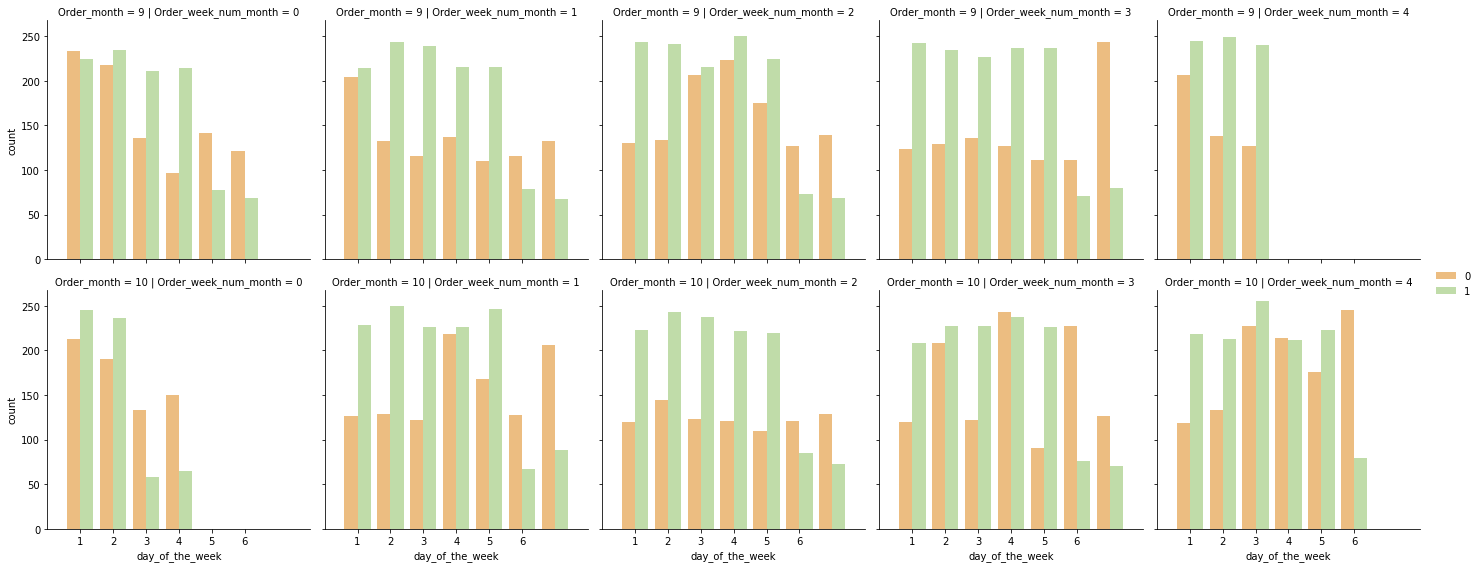

In [ ]:
plots = sns.FacetGrid(df_train, row='Order_month', col='Order_week_num_month', height=4)
plots.map(sns.countplot, 'day_of_the_week', hue=df_train['Office'], palette='Spectral')
plots.set(xlim=(-1, 7))
plots.add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


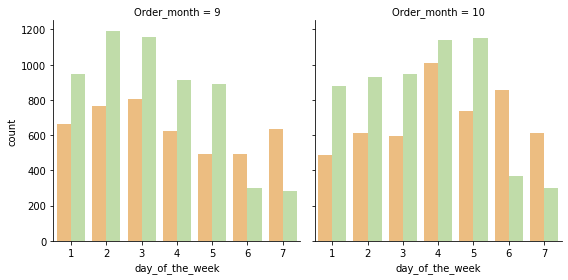

In [ ]:
plots = sns.FacetGrid(df_train, col='Order_month', height=4)
plots.map(sns.countplot, 'day_of_the_week', hue=df_train['Office'], palette='Spectral')

Оценим влияние дождливости на соотношение заказов на дом и в офис. Для этого построим графики количества заказов на дом, выделив темным цветом дождливые дни. Сравним результаты для разных недель между собой:

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


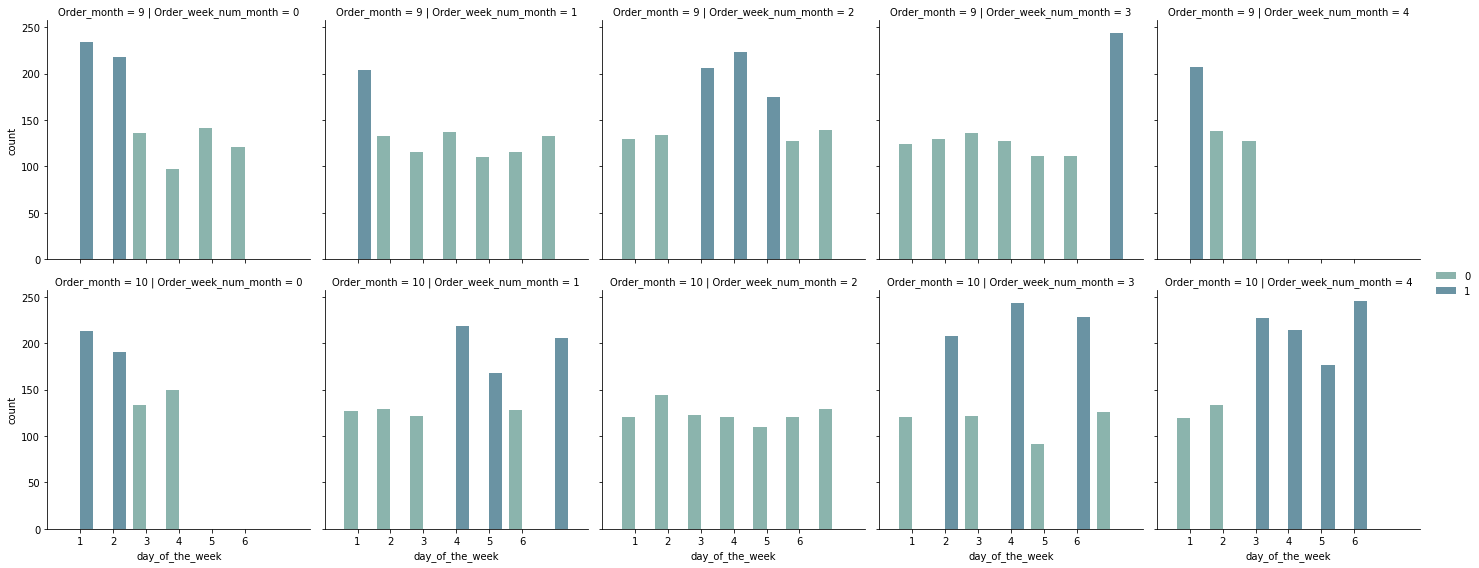

In [ ]:
plots = sns.FacetGrid(df_train[df_train['Office'] == 0], row='Order_month', col='Order_week_num_month', height=4)
plots.map(sns.countplot, 'day_of_the_week', hue=df_train['Rain'], palette='crest', alpha=0.7)
plots.set(xlim=(-1, 7))
plots.add_legend()

Теперь построим графики количества заказов в офис:

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


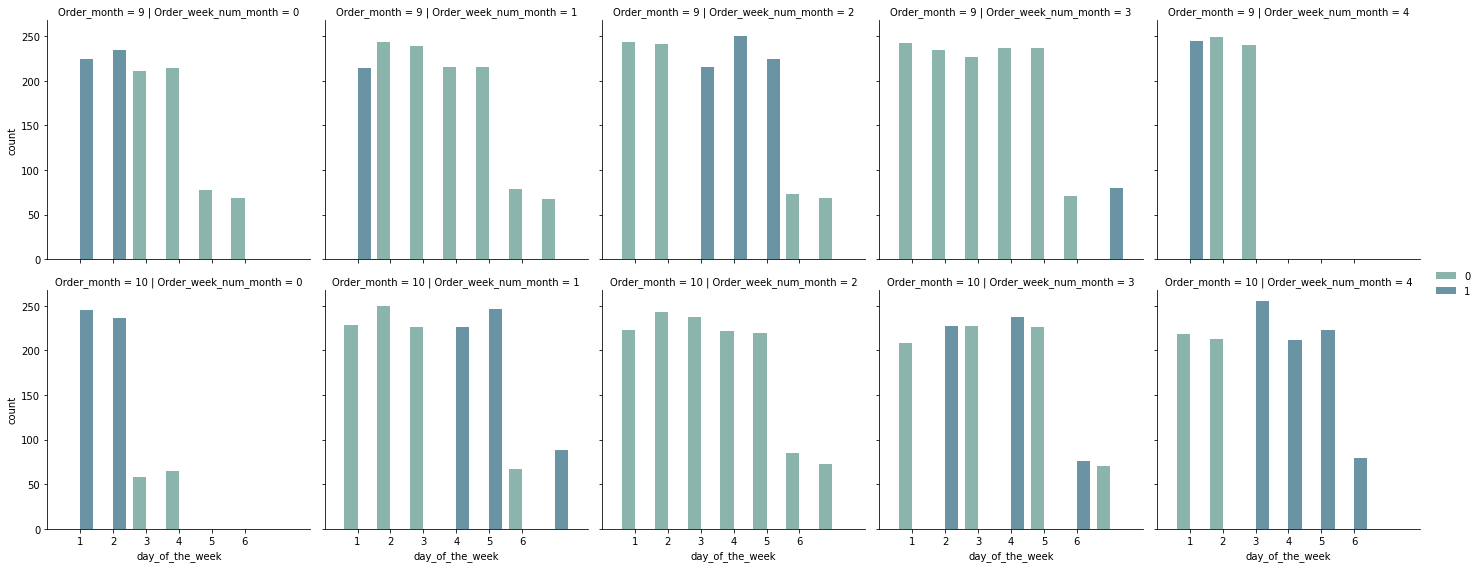

In [ ]:
plots = sns.FacetGrid(df_train[df_train['Office'] == 1], row='Order_month', col='Order_week_num_month', height=4)
plots.map(sns.countplot, 'day_of_the_week', hue=df_train['Rain'], palette='crest', alpha=0.7)
plots.set(xlim=(-1, 7))
plots.add_legend()

Из графиков видно, что заказов на дом становится гораздо больше в дождливые дни. Количество заказов в офис при этом не изменяется. Поэтому при определении вероятности доставки на дом и в офис дождливость даст дополнительный вес в пользу заказа на дом

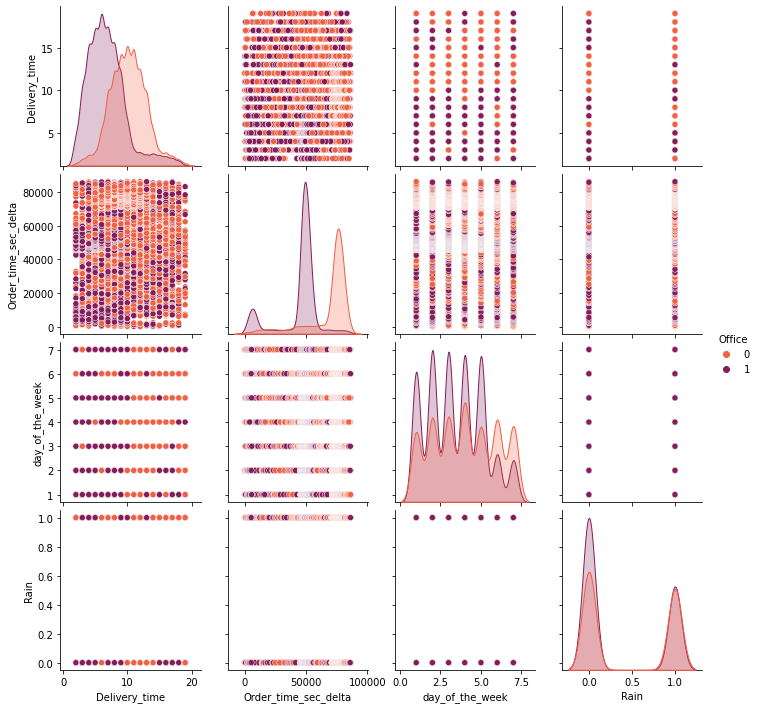

In [ ]:
sns.pairplot(df_train[['Office', 'Delivery_time', 'Order_time_sec_delta', 'day_of_the_week', 'Rain']], hue='Office', palette='rocket_r')

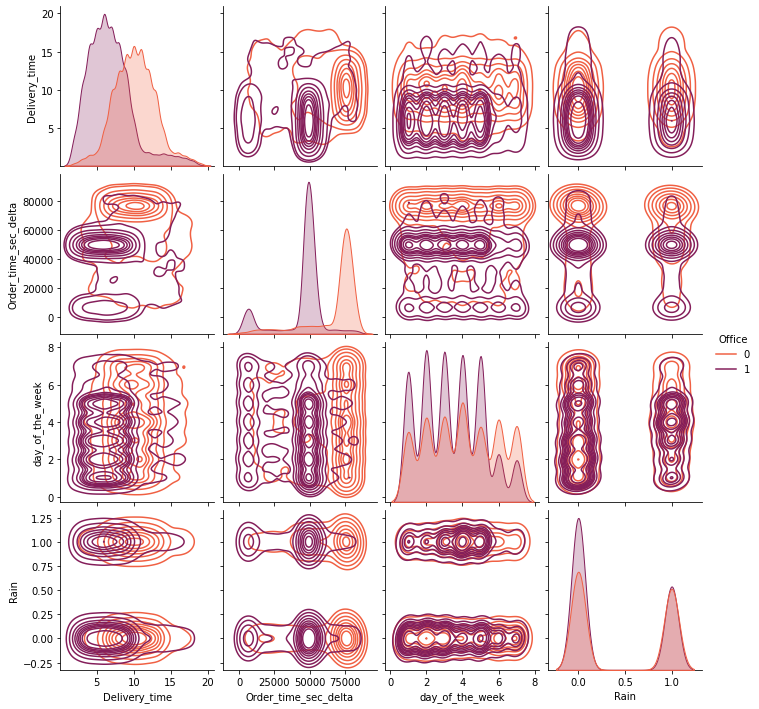

In [10]:
sns.pairplot(df_train[['Office', 'Delivery_time', 'Order_time_sec_delta', 'day_of_the_week', 'Rain']], hue='Office', palette='rocket_r', kind="kde")

Параметры day_of_the_week и Rain способны улучшить модель, разделяющую данные по времени заказа и времени доставки, однако, в чистом виде они лишь вносят неупорядоченность в модель. Попробуем создать из этих параметров новые, по которым данные были бы линейно разделимы

Найдем средние значения параметра Delivery_time для доставок на дом и доставок в офис в дни с хорошей погодой. Разница между этими значениями поможет определить степень сдвига в область доставки на дом в случае дождя

In [11]:
rain_delivery_delta = df_train[(df_train['Office'] == 0) & (df_train['Rain'] == 0)]['Delivery_time'].mean() - df_train[(df_train['Office'] == 1) & (df_train['Rain'] == 0)]['Delivery_time'].mean()
rain_delivery_delta

3.345652438199302

In [12]:
df_train['Delivery_time_Rain'] = df_train['Delivery_time'] + df_train['Rain'] * rain_delivery_delta
df_train

Order_date_time  Delivery_time  Office  Rain  Order_date  \
0       2020-09-01 0:15:10             10       1     1  2020-09-01   
1       2020-09-01 0:17:38              5       1     1  2020-09-01   
2       2020-09-01 0:20:23             17       1     1  2020-09-01   
3       2020-09-01 0:29:52             12       0     1  2020-09-01   
4       2020-09-01 0:32:52              9       1     1  2020-09-01   
...                    ...            ...     ...   ...         ...   
20786  2020-10-31 23:28:08              4       1     1  2020-10-31   
20787  2020-10-31 23:39:56             10       1     1  2020-10-31   
20788  2020-10-31 23:43:11              9       1     1  2020-10-31   
20789  2020-10-31 23:47:56              9       1     1  2020-10-31   
20790  2020-10-31 23:48:52              5       1     1  2020-10-31   

      Order_time  day_of_the_week  Order_time_sec  Order_year  Order_month  \
0        0:15:10                2             910        2020            9   
1        0:17:38                2            1058        2020            9   
2        0:20:23                2            1223        2020            9   
3        0:29:52                2            1792        2020            9   
4        0:32:52                2            1972        2020            9   
...          ...              ...             ...         ...          ...   
20786   23:28:08                6           84488        2020           10   
20787   23:39:56                6           85196        2020           10   
20788   23:43:11                6           85391        2020           10   
20789   23:47:56                6           85676        2020           10   
20790   23:48:52                6           85732        2020           10   

       Order_day  Order_hour  Order_week_num_year  Order_week_num_month  \
0              1           0                   36                     0   
1              1           0                   36                     0   
2              1           0                   36                     0   
3              1           0                   36                     0   
4              1           0                   36                     0   
...          ...         ...                  ...                   ...   
20786         31          23                   44                     4   
20787         31          23                   44                     4   
20788         31          23                   44                     4   
20789         31          23                   44                     4   
20790         31          23                   44                     4   

       Order_time_sec_delta  Delivery_time_Rain  
0                      6910           13.345652  
1                      7058            8.345652  
2                      7223           20.345652  
3                      7792           15.345652  
4                      7972           12.345652  
...                     ...                 ...  
20786                  4088            7.345652  
20787                  4796           13.345652  
20788                  4991           12.345652  
20789                  5276           12.345652  
20790                  5332            8.345652  

[20791 rows x 16 columns]

Дождливая погода дает нам право использовать этот признак для создания перевеса в сторону доставки на дом. Отсутствие дождя никак не влияет на данные о заказе. Поэтому мы можем заполнить нулями все пропущенные даннные в тестовом наборе для создания нового столбца Delivery_time_Rain

In [13]:
df_test['Nan_Rain_to_0'] = df_test['Rain'].fillna(0)

In [14]:
df_test['Delivery_time_Rain'] = df_test['Delivery_time'] + df_test['Nan_Rain_to_0'] * rain_delivery_delta
df_test

Order_date_time  Delivery_time  Office  Rain  Order_date Order_time  \
0      2020-11-01 0:02:37              3       1   0.0  2020-11-01    0:02:37   
1      2020-11-01 0:09:50             15       0   0.0  2020-11-01    0:09:50   
2      2020-11-01 0:10:35              7       1   0.0  2020-11-01    0:10:35   
3      2020-11-01 0:13:08              8       1   0.0  2020-11-01    0:13:08   
4      2020-11-01 0:22:38              7       1   0.0  2020-11-01    0:22:38   
...                   ...            ...     ...   ...         ...        ...   
5468  2020-11-15 23:36:56              6       1   NaN  2020-11-15   23:36:56   
5469  2020-11-15 23:43:57              8       1   NaN  2020-11-15   23:43:57   
5470  2020-11-15 23:45:35              6       1   NaN  2020-11-15   23:45:35   
5471  2020-11-15 23:49:25              3       1   NaN  2020-11-15   23:49:25   
5472  2020-11-15 23:56:46              6       1   NaN  2020-11-15   23:56:46   

      day_of_the_week  Order_time_sec  Order_year  Order_month  Order_day  \
0                   7             157        2020           11          1   
1                   7             590        2020           11          1   
2                   7             635        2020           11          1   
3                   7             788        2020           11          1   
4                   7            1358        2020           11          1   
...               ...             ...         ...          ...        ...   
5468                7           85016        2020           11         15   
5469                7           85437        2020           11         15   
5470                7           85535        2020           11         15   
5471                7           85765        2020           11         15   
5472                7           86206        2020           11         15   

      Order_hour  Order_week_num_year  Order_week_num_month  \
0              0                   44                     0   
1              0                   44                     0   
2              0                   44                     0   
3              0                   44                     0   
4              0                   44                     0   
...          ...                  ...                   ...   
5468          23                   46                     2   
5469          23                   46                     2   
5470          23                   46                     2   
5471          23                   46                     2   
5472          23                   46                     2   

      Order_time_sec_delta  Nan_Rain_to_0  Delivery_time_Rain  
0                     6157            0.0                 3.0  
1                     6590            0.0                15.0  
2                     6635            0.0                 7.0  
3                     6788            0.0                 8.0  
4                     7358            0.0                 7.0  
...                    ...            ...                 ...  
5468                  4616            0.0                 6.0  
5469                  5037            0.0                 8.0  
5470                  5135            0.0                 6.0  
5471                  5365            0.0                 3.0  
5472                  5806            0.0                 6.0  

[5473 rows x 17 columns]

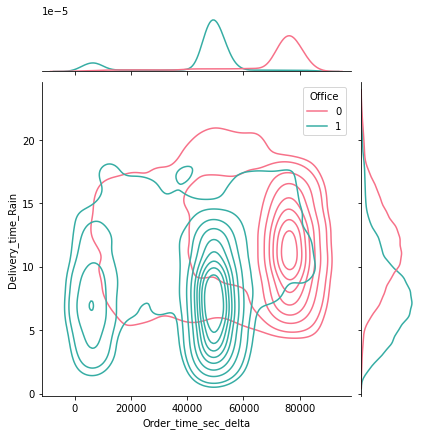

In [ ]:
sns.jointplot(x=df_train['Order_time_sec_delta'], y=df_train['Delivery_time_Rain'], hue=df_train['Office'], palette='husl', kind="kde")

Видно, что внесенные изменения пошли на пользу классификации. Интерпретировать можно следующим образом: время доставки в жилые районы во время дождя увеличивается. Попробуем еще увеличить этот полезный параметр

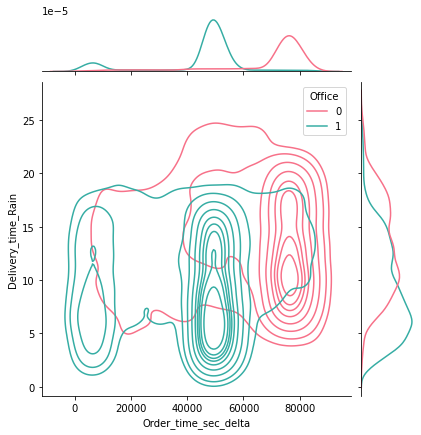

In [15]:
df_train['Delivery_time_Rain'] = df_train['Delivery_time'] + df_train['Rain'] * rain_delivery_delta * 2
df_test['Delivery_time_Rain'] = df_test['Delivery_time'] + df_test['Nan_Rain_to_0'] * rain_delivery_delta * 2
sns.jointplot(x=df_train['Order_time_sec_delta'], y=df_train['Delivery_time_Rain'], hue=df_train['Office'], palette='husl', kind="kde")

Так было:

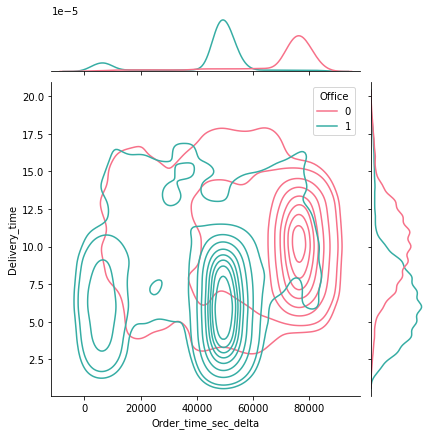

In [16]:
sns.jointplot(x=df_train['Order_time_sec_delta'], y=df_train['Delivery_time'], hue=df_train['Office'], palette='husl', kind="kde")

Внесем подобные изменения в параметр Order_time_sec_delta, считая, что клиенты в дождливые дни начинают заказывать еду заблаговременно

In [17]:
rain_order_time_delta = df_train[(df_train['Office'] == 0) & (df_train['Rain'] == 0)]['Order_time_sec_delta'].mean() - df_train[(df_train['Office'] == 1) & (df_train['Rain'] == 0)]['Order_time_sec_delta'].mean()
rain_order_time_delta

24925.029132142066

In [18]:
df_train['Order_time_sec_delta_Rain'] = (df_train['Order_time_sec_delta'] + df_train['Rain'] * rain_order_time_delta) % 86400
df_train

Order_date_time  Delivery_time  Office  Rain  Order_date  \
0       2020-09-01 0:15:10             10       1     1  2020-09-01   
1       2020-09-01 0:17:38              5       1     1  2020-09-01   
2       2020-09-01 0:20:23             17       1     1  2020-09-01   
3       2020-09-01 0:29:52             12       0     1  2020-09-01   
4       2020-09-01 0:32:52              9       1     1  2020-09-01   
...                    ...            ...     ...   ...         ...   
20786  2020-10-31 23:28:08              4       1     1  2020-10-31   
20787  2020-10-31 23:39:56             10       1     1  2020-10-31   
20788  2020-10-31 23:43:11              9       1     1  2020-10-31   
20789  2020-10-31 23:47:56              9       1     1  2020-10-31   
20790  2020-10-31 23:48:52              5       1     1  2020-10-31   

      Order_time  day_of_the_week  Order_time_sec  Order_year  Order_month  \
0        0:15:10                2             910        2020            9   
1        0:17:38                2            1058        2020            9   
2        0:20:23                2            1223        2020            9   
3        0:29:52                2            1792        2020            9   
4        0:32:52                2            1972        2020            9   
...          ...              ...             ...         ...          ...   
20786   23:28:08                6           84488        2020           10   
20787   23:39:56                6           85196        2020           10   
20788   23:43:11                6           85391        2020           10   
20789   23:47:56                6           85676        2020           10   
20790   23:48:52                6           85732        2020           10   

       Order_day  Order_hour  Order_week_num_year  Order_week_num_month  \
0              1           0                   36                     0   
1              1           0                   36                     0   
2              1           0                   36                     0   
3              1           0                   36                     0   
4              1           0                   36                     0   
...          ...         ...                  ...                   ...   
20786         31          23                   44                     4   
20787         31          23                   44                     4   
20788         31          23                   44                     4   
20789         31          23                   44                     4   
20790         31          23                   44                     4   

       Order_time_sec_delta  Delivery_time_Rain  Order_time_sec_delta_Rain  
0                      6910           16.691305               31835.029132  
1                      7058           11.691305               31983.029132  
2                      7223           23.691305               32148.029132  
3                      7792           18.691305               32717.029132  
4                      7972           15.691305               32897.029132  
...                     ...                 ...                        ...  
20786                  4088           10.691305               29013.029132  
20787                  4796           16.691305               29721.029132  
20788                  4991           15.691305               29916.029132  
20789                  5276           15.691305               30201.029132  
20790                  5332           11.691305               30257.029132  

[20791 rows x 17 columns]

In [19]:
df_test['Order_time_sec_delta_Rain'] = (df_test['Order_time_sec_delta'] + df_test['Nan_Rain_to_0'] * rain_order_time_delta) % 86400
df_test

Order_date_time  Delivery_time  Office  Rain  Order_date Order_time  \
0      2020-11-01 0:02:37              3       1   0.0  2020-11-01    0:02:37   
1      2020-11-01 0:09:50             15       0   0.0  2020-11-01    0:09:50   
2      2020-11-01 0:10:35              7       1   0.0  2020-11-01    0:10:35   
3      2020-11-01 0:13:08              8       1   0.0  2020-11-01    0:13:08   
4      2020-11-01 0:22:38              7       1   0.0  2020-11-01    0:22:38   
...                   ...            ...     ...   ...         ...        ...   
5468  2020-11-15 23:36:56              6       1   NaN  2020-11-15   23:36:56   
5469  2020-11-15 23:43:57              8       1   NaN  2020-11-15   23:43:57   
5470  2020-11-15 23:45:35              6       1   NaN  2020-11-15   23:45:35   
5471  2020-11-15 23:49:25              3       1   NaN  2020-11-15   23:49:25   
5472  2020-11-15 23:56:46              6       1   NaN  2020-11-15   23:56:46   

      day_of_the_week  Order_time_sec  Order_year  Order_month  Order_day  \
0                   7             157        2020           11          1   
1                   7             590        2020           11          1   
2                   7             635        2020           11          1   
3                   7             788        2020           11          1   
4                   7            1358        2020           11          1   
...               ...             ...         ...          ...        ...   
5468                7           85016        2020           11         15   
5469                7           85437        2020           11         15   
5470                7           85535        2020           11         15   
5471                7           85765        2020           11         15   
5472                7           86206        2020           11         15   

      Order_hour  Order_week_num_year  Order_week_num_month  \
0              0                   44                     0   
1              0                   44                     0   
2              0                   44                     0   
3              0                   44                     0   
4              0                   44                     0   
...          ...                  ...                   ...   
5468          23                   46                     2   
5469          23                   46                     2   
5470          23                   46                     2   
5471          23                   46                     2   
5472          23                   46                     2   

      Order_time_sec_delta  Nan_Rain_to_0  Delivery_time_Rain  \
0                     6157            0.0                 3.0   
1                     6590            0.0                15.0   
2                     6635            0.0                 7.0   
3                     6788            0.0                 8.0   
4                     7358            0.0                 7.0   
...                    ...            ...                 ...   
5468                  4616            0.0                 6.0   
5469                  5037            0.0                 8.0   
5470                  5135            0.0                 6.0   
5471                  5365            0.0                 3.0   
5472                  5806            0.0                 6.0   

      Order_time_sec_delta_Rain  
0                        6157.0  
1                        6590.0  
2                        6635.0  
3                        6788.0  
4                        7358.0  
...                         ...  
5468                     4616.0  
5469                     5037.0  
5470                     5135.0  
5471                     5365.0  
5472                     5806.0  

[5473 rows x 18 columns]

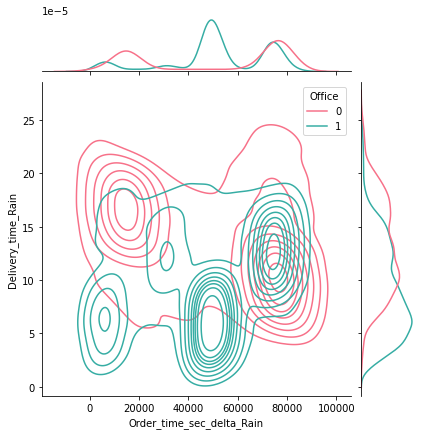

In [20]:
sns.jointplot(x=df_train['Order_time_sec_delta_Rain'], y=df_train['Delivery_time_Rain'], hue=df_train['Office'], palette='husl', kind="kde")

Гипотеза провалилась, люди не заказывают еду заблаговременно. По крайней мере, за 6,5 - 7 часов до нужного времени. Дополнительное времяв 30 минут на доставку не меняет картину, признак не имеет влияния на время заказа

Теперь рассмотрим влияние выходных дней. В выходные резко снижается количество доставок в офис, при этом количество доставок домой остается на том же уровне, что и в будни.

In [21]:
weekend_order_time_delta = df_train[(df_train['Office'] == 0) & (df_train['day_of_the_week'] < 6)]['Order_time_sec_delta'].mean() - df_train[(df_train['Office'] == 1) & (df_train['day_of_the_week'] < 6)]['Order_time_sec_delta'].mean()
weekend_order_time_delta

22391.30063490854

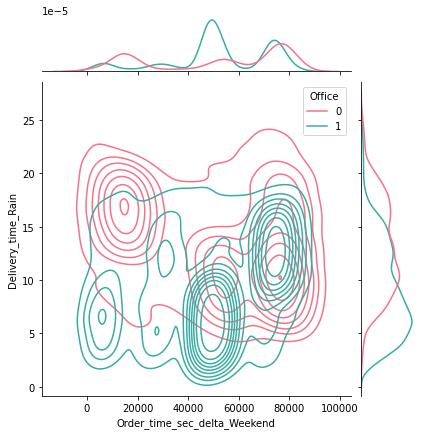

In [22]:
df_train['Order_time_sec_delta_Weekend'] = (df_train['Order_time_sec_delta_Rain'] - (df_train['day_of_the_week'] >= 6) * weekend_order_time_delta + 86400) % 86400
df_test['Order_time_sec_delta_Weekend'] = (df_test['Order_time_sec_delta_Rain'] - (df_test['day_of_the_week'] >= 6) * weekend_order_time_delta + 86400) % 86400
sns.jointplot(x=df_train['Order_time_sec_delta_Weekend'], y=df_train['Delivery_time_Rain'], hue=df_train['Office'], palette='husl', kind="kde")

Данные сильно перемешались. Поздние заказы на дом были истолкованы как заказы в офис, а заказы в офис столкованы как ранние заказы на дом. Интерпретация гипотезы: в выходные люди иногда заказывают в офис позже, чем обычно на примерно на 6 часов. 6 часов - слишком неправдоподобная задержка. Попробуем уменьшить влияние данного фактора

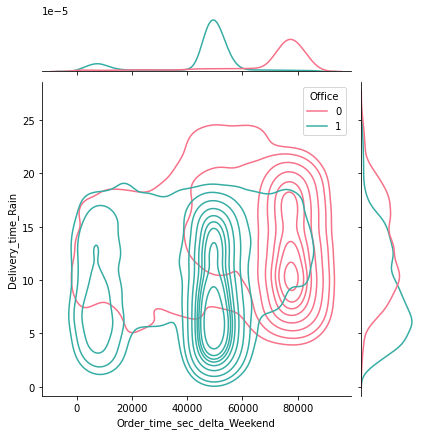

In [23]:
df_train['Order_time_sec_delta_Weekend'] = (df_train['Order_time_sec_delta'] + (df_train['day_of_the_week'] > 5) * weekend_order_time_delta * 0.2 + 86400) % 86400
df_test['Order_time_sec_delta_Weekend'] = (df_test['Order_time_sec_delta'] + (df_test['day_of_the_week'] > 5 ) * weekend_order_time_delta * 0.2 + 86400) % 86400
sns.jointplot(x=df_train['Order_time_sec_delta_Weekend'], y=df_train['Delivery_time_Rain'], hue=df_train['Office'], palette='husl', kind="kde")

Картина становится только хуже. Зависимости между днем недели и временем заказа нет

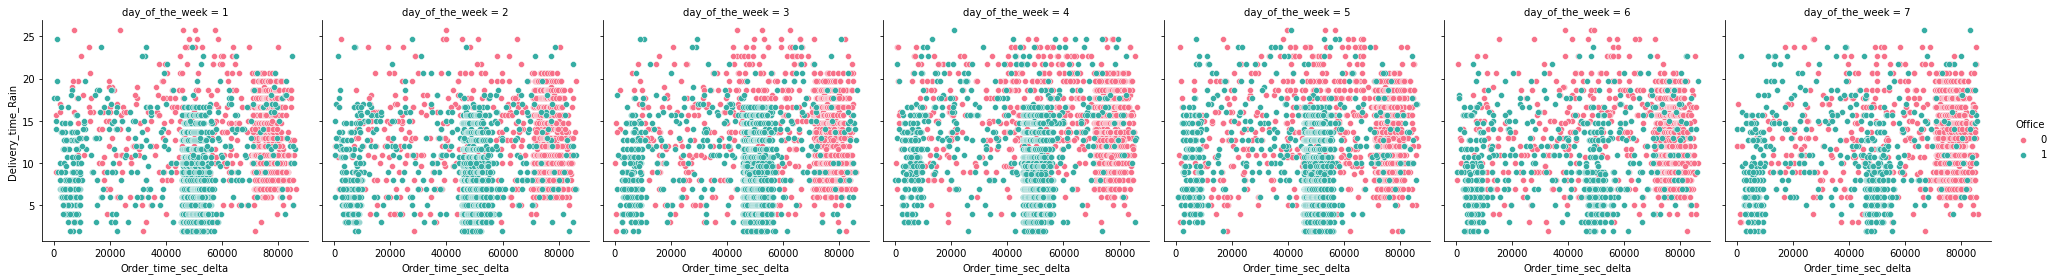

In [ ]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='husl', height=4)
plots.map(sns.scatterplot, 'Order_time_sec_delta', 'Delivery_time_Rain')
plots.add_legend()

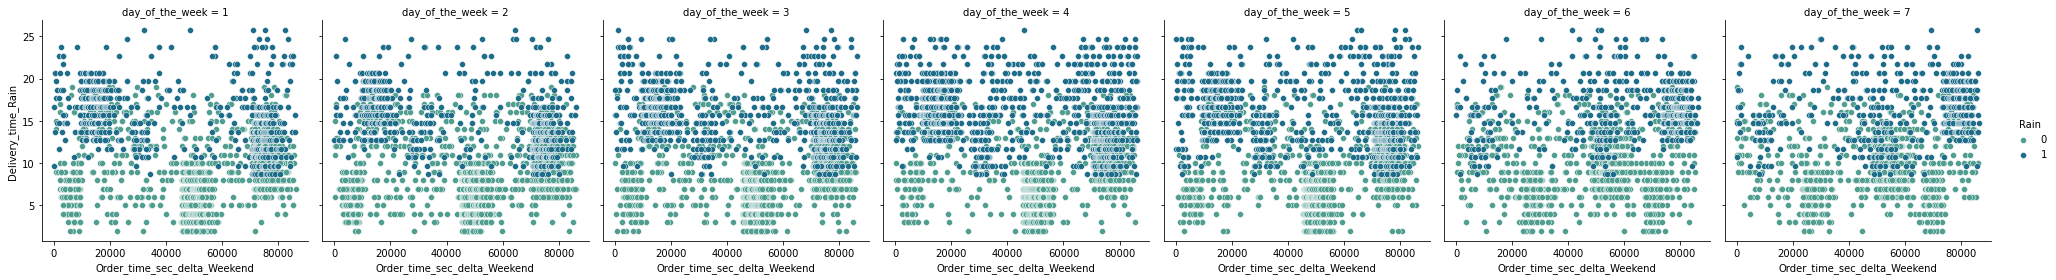

In [ ]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Rain', palette='crest', height=4)
plots.map(sns.scatterplot, 'Order_time_sec_delta_Weekend', 'Delivery_time_Rain')
plots.add_legend()

In [24]:
weekend_delivery_time_delta = df_train[(df_train['Office'] == 0) & (df_train['day_of_the_week'] < 6)]['Delivery_time_Rain'].mean() - df_train[(df_train['Office'] == 1) & (df_train['day_of_the_week'] < 6)]['Delivery_time_Rain'].mean()
weekend_delivery_time_delta

4.297868823733088

Заказы в офис в рабочие дни очень быстрые:

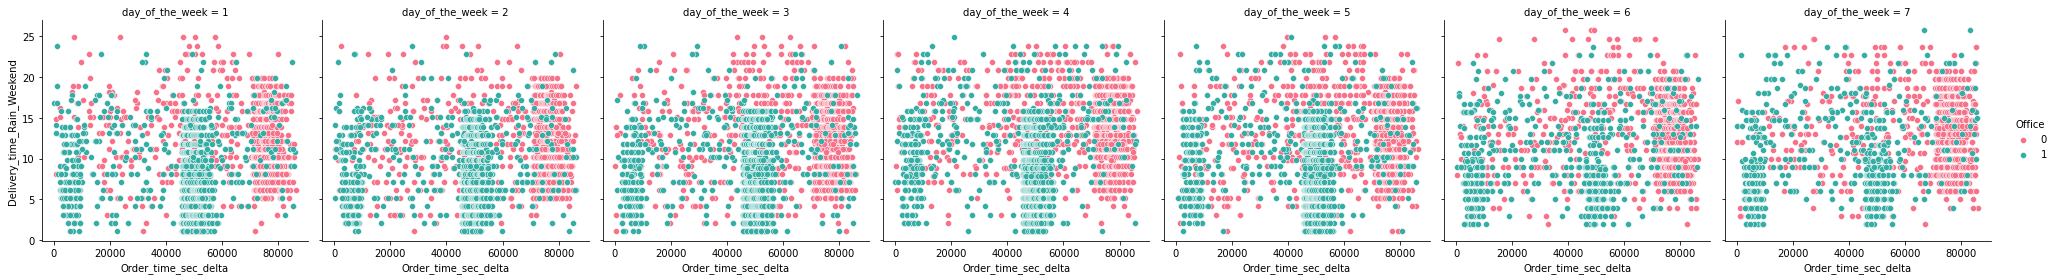

In [25]:
df_train['Delivery_time_Rain_Weekend'] = df_train['Delivery_time_Rain'] - (df_train['day_of_the_week'] < 6) * weekend_delivery_time_delta * 0.2
df_test['Delivery_time_Rain_Weekend'] = df_test['Delivery_time_Rain'] - (df_test['day_of_the_week'] < 6) * weekend_delivery_time_delta * 0.2
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='husl', height=4)
plots.map(sns.scatterplot, 'Order_time_sec_delta', 'Delivery_time_Rain_Weekend')
plots.add_legend()

Распределение стало более равномерным по дням недели

In [26]:
import math
import numpy as np

df_train['Order_time_sin'] = (np.sin(((df_train['Order_time_sec_delta'] + 9000) % 86400) * math.pi / 43200) + 1.5) % 2 - 1
df_train['Order_time_cos'] = (np.cos(((df_train['Order_time_sec_delta'] + 12000) % 86400) * math.pi / 43200) + 1.5) % 2 - 1
df_test['Order_time_sin'] = (np.sin(((df_test['Order_time_sec_delta'] + 9000) % 86400) * math.pi / 43200) + 1.5) % 2 - 1
df_test['Order_time_cos'] = (np.cos(((df_test['Order_time_sec_delta'] + 12000) % 86400) * math.pi / 43200) + 1.5) % 2 - 1

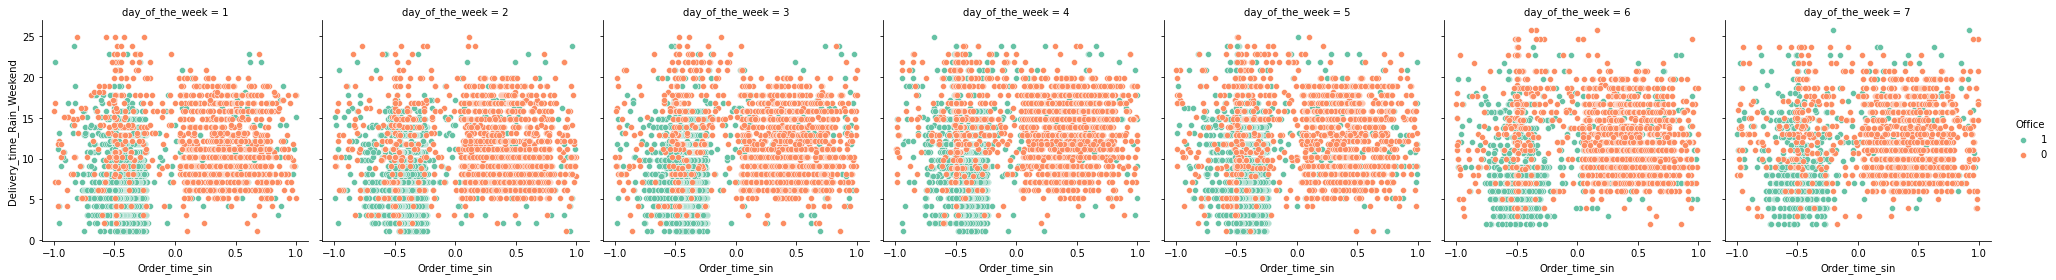

In [27]:
import seaborn as sns
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='Set2', height=4, hue_order=[1, 0])
plots.map(sns.scatterplot, 'Order_time_sin', 'Delivery_time_Rain_Weekend')
plots.add_legend()

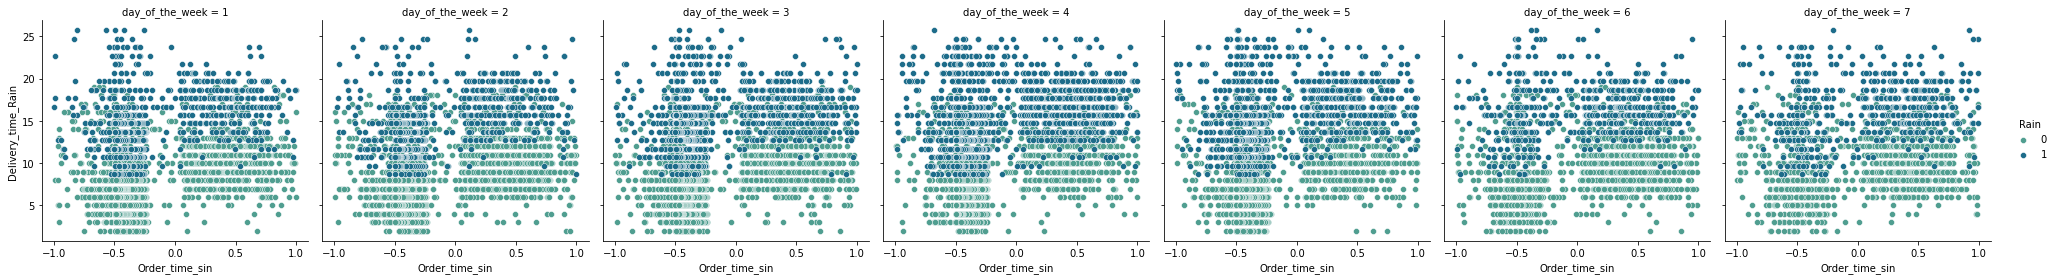

In [28]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Rain', palette='crest', height=4)
plots.map(sns.scatterplot, 'Order_time_sin', 'Delivery_time_Rain')
plots.add_legend()

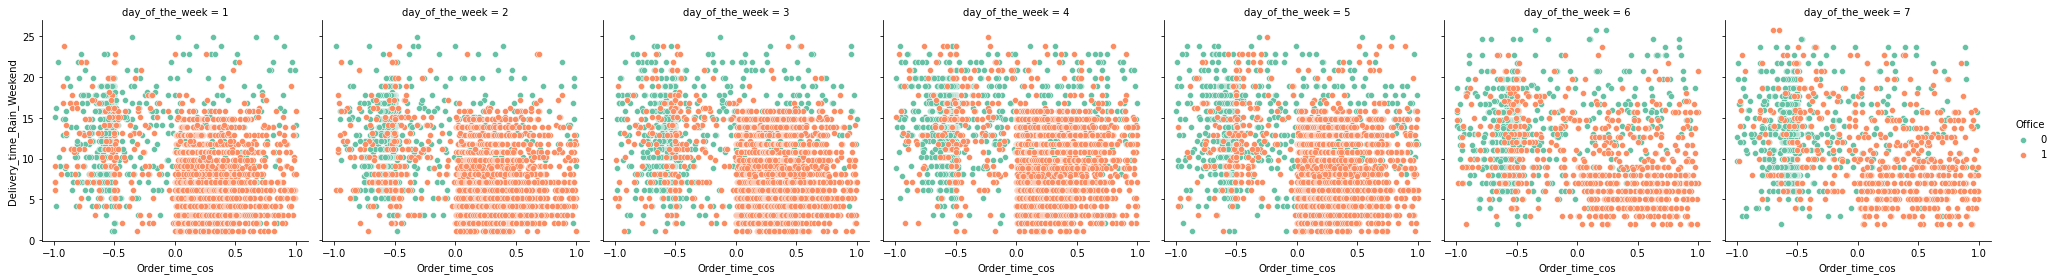

In [29]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='Set2', height=4)
plots.map(sns.scatterplot, 'Order_time_cos', 'Delivery_time_Rain_Weekend')
plots.add_legend()

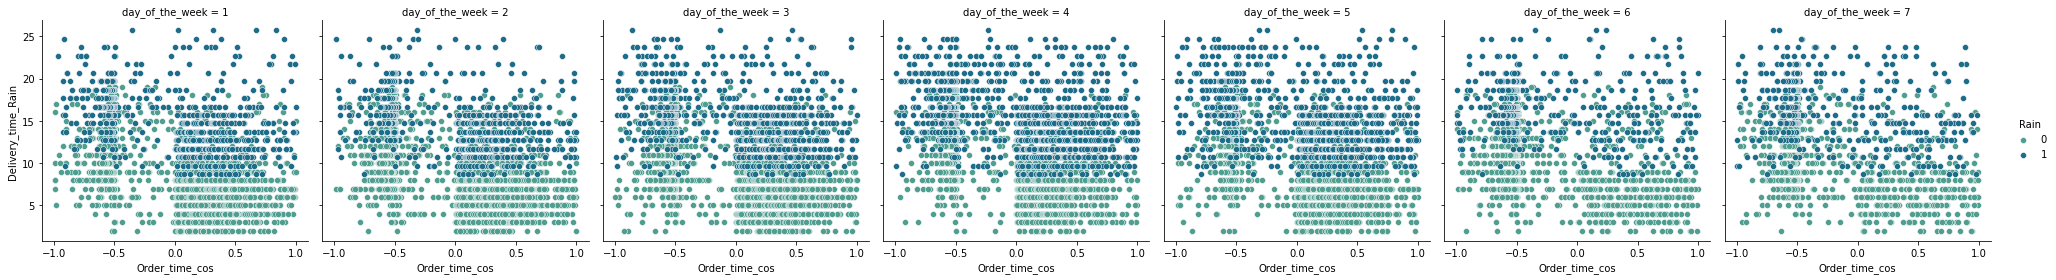

In [30]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Rain', palette='crest', height=4)
plots.map(sns.scatterplot, 'Order_time_cos', 'Delivery_time_Rain')
plots.add_legend()

Используем параметр дождливость

In [31]:
df_train['Order_time_sin_delta'] = df_train['Order_time_sin'] - (df_train['Rain'] == 0) * 0.5
df_train['Order_time_cos_delta'] = df_train['Order_time_cos'] + (df_train['Rain'] == 0) * 0.5
df_test['Order_time_sin_delta'] = df_test['Order_time_sin'] - (df_test['Rain'] == 0) * 0.5
df_test['Order_time_cos_delta'] = df_test['Order_time_cos'] + (df_test['Rain'] == 0) * 0.5

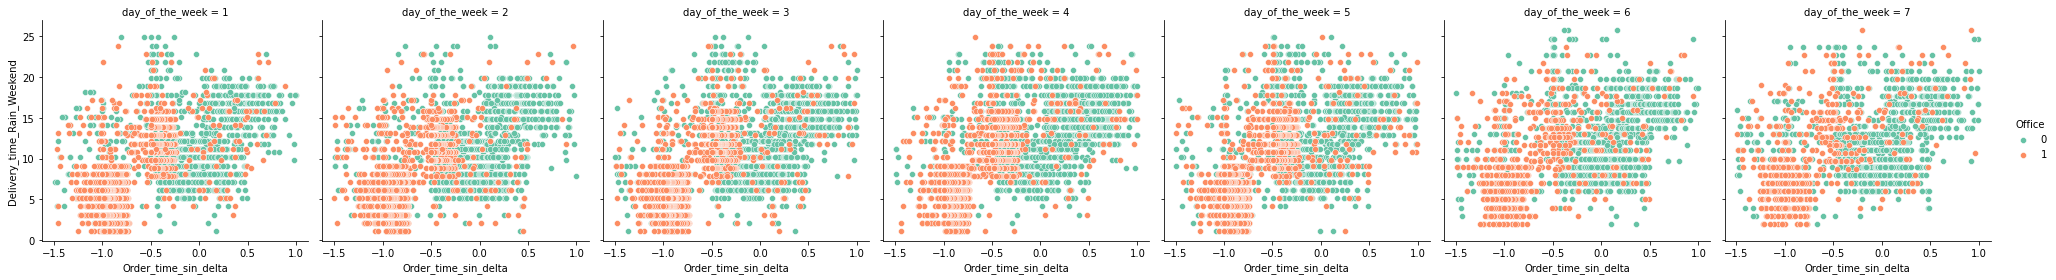

In [32]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='Set2', height=4)
plots.map(sns.scatterplot, 'Order_time_sin_delta', 'Delivery_time_Rain_Weekend')
plots.add_legend()

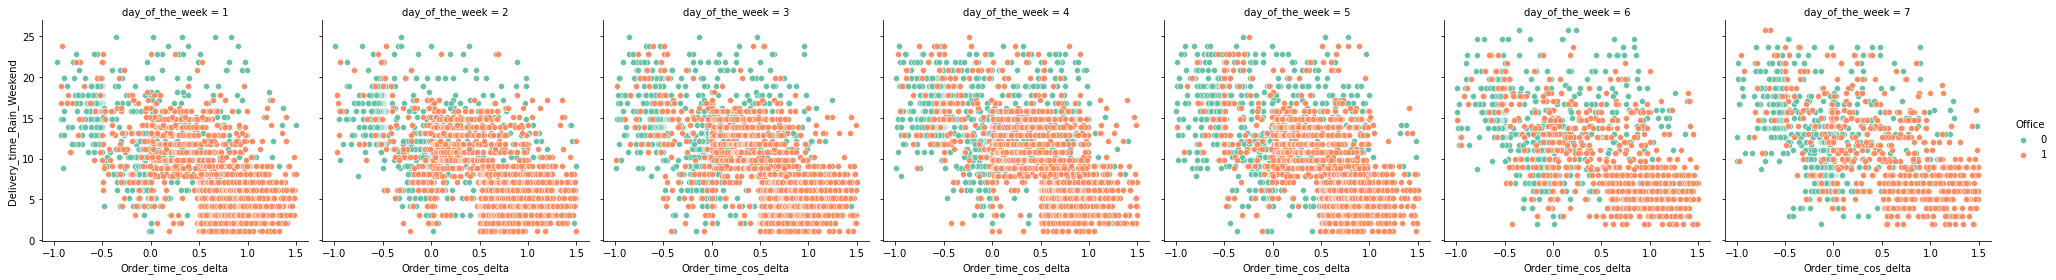

In [33]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='Set2', height=4)
plots.map(sns.scatterplot, 'Order_time_cos_delta', 'Delivery_time_Rain_Weekend')
plots.add_legend()

Попробуем изменить влияние параметра

In [34]:
df_train['Order_time_sin_delta2'] = df_train['Order_time_sin'] + (df_train['Rain'] == 0) * 0.5
df_train['Order_time_cos_delta2'] = df_train['Order_time_cos'] - (df_train['Rain'] == 0) * 0.5
df_test['Order_time_sin_delta2'] = df_test['Order_time_sin'] + (df_test['Rain'] == 0) * 0.5
df_test['Order_time_cos_delta2'] = df_test['Order_time_cos'] - (df_test['Rain'] == 0) * 0.5

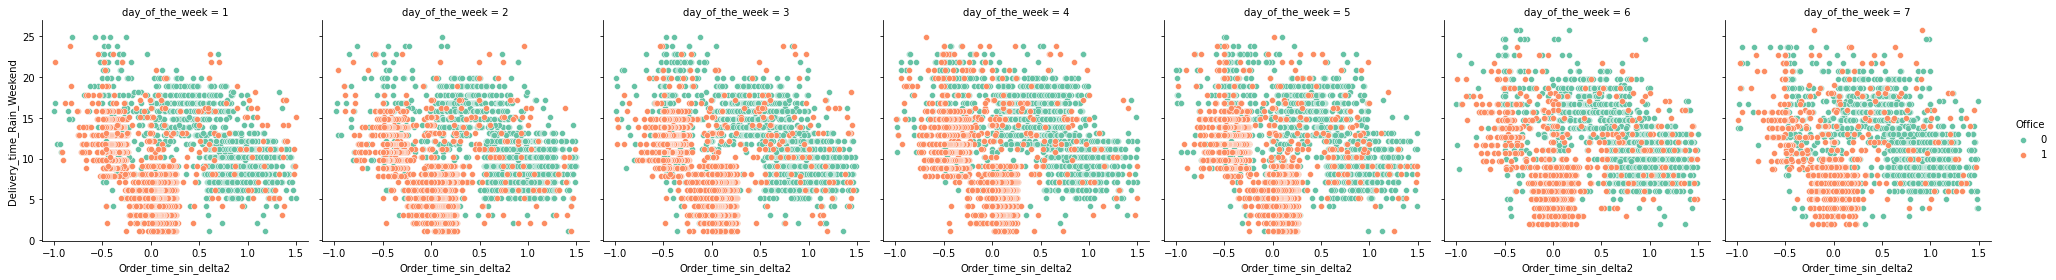

In [35]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='Set2', height=4)
plots.map(sns.scatterplot, 'Order_time_sin_delta2', 'Delivery_time_Rain_Weekend')
plots.add_legend()

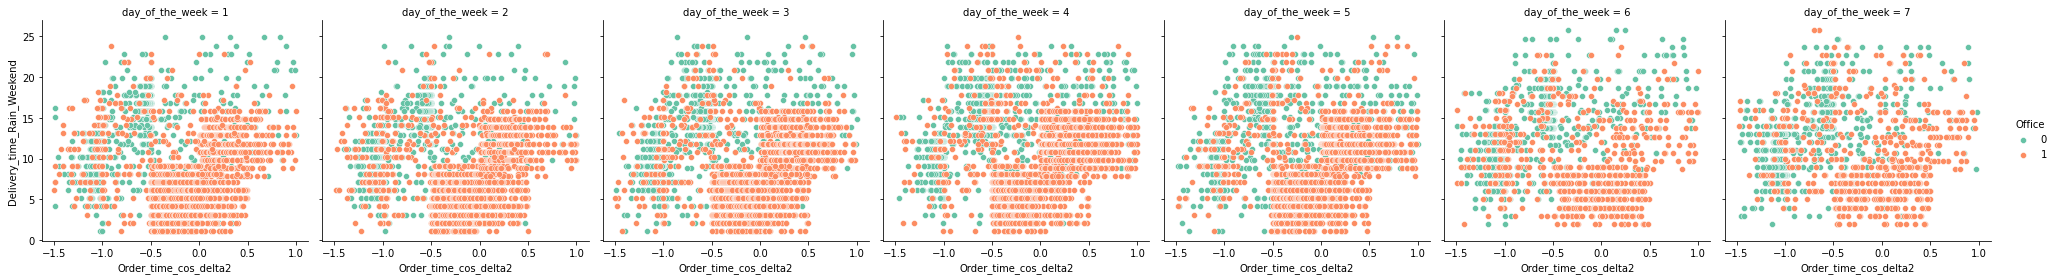

In [36]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', palette='Set2', height=4)
plots.map(sns.scatterplot, 'Order_time_cos_delta2', 'Delivery_time_Rain_Weekend')
plots.add_legend()

Используем синус и косинус для Delivery_time

In [37]:
df_train['Delivery_sin'] = np.sin(df_train['Delivery_time_Rain_Weekend'] * math.pi / 12)
df_train['Delivery_cos'] = np.cos(df_train['Delivery_time_Rain_Weekend'] * math.pi / 12)
df_test['Delivery_sin'] = np.sin(df_test['Delivery_time_Rain_Weekend'] * math.pi / 12)
df_test['Delivery_cos'] = np.cos(df_test['Delivery_time_Rain_Weekend'] * math.pi / 12)

In [38]:
df_train.describe()

Delivery_time        Office          Rain  day_of_the_week  \
count   20791.000000  20791.000000  20791.000000     20791.000000   
mean        8.283440      0.548410      0.398730         3.680872   
std         3.372459      0.497663      0.489649         1.834987   
min         2.000000      0.000000      0.000000         1.000000   
25%         6.000000      0.000000      0.000000         2.000000   
50%         8.000000      1.000000      0.000000         4.000000   
75%        10.000000      1.000000      1.000000         5.000000   
max        19.000000      1.000000      1.000000         7.000000   

       Order_time_sec  Order_year   Order_month     Order_day    Order_hour  \
count    20791.000000     20791.0  20791.000000  20791.000000  20791.000000   
mean     51790.927613      2020.0      9.510894     15.852003     13.885624   
std      19511.018745         0.0      0.499893      9.018616      5.413014   
min          6.000000      2020.0      9.000000      1.000000      0.000000   
25%      41833.500000      2020.0      9.000000      8.000000     11.000000   
50%      46638.000000      2020.0     10.000000     16.000000     12.000000   
75%      69497.500000      2020.0     10.000000     24.000000     19.000000   
max      86393.000000      2020.0     10.000000     31.000000     23.000000   

       Order_week_num_year  ...  Order_time_sec_delta_Weekend  \
count         20791.000000  ...                  20791.000000   
mean             40.071137  ...                  55174.950663   
std               2.534360  ...                  21332.124953   
min              36.000000  ...                     28.260127   
25%              38.000000  ...                  47245.500000   
50%              40.000000  ...                  52148.000000   
75%              42.000000  ...                  75413.000000   
max              44.000000  ...                  86376.260127   

       Delivery_time_Rain_Weekend  Order_time_sin  Order_time_cos  \
count                20791.000000    20791.000000    20791.000000   
mean                    10.251023       -0.092728       -0.056993   
std                      4.870752        0.464853        0.486869   
min                      1.140426       -0.999937       -0.999056   
25%                      6.140426       -0.453279       -0.512615   
50%                     10.000000       -0.307947        0.035609   
75%                     13.831731        0.331511        0.340226   
max                     25.691305        0.999685        0.999937   

       Order_time_sin_delta  Order_time_cos_delta  Order_time_sin_delta2  \
count          20791.000000          20791.000000           20791.000000   
mean              -0.393363              0.243642               0.207906   
std                0.527859              0.552231               0.522895   
min               -1.497546             -0.999056              -0.999937   
25%               -0.871446             -0.082014              -0.210152   
50%               -0.428594              0.158937               0.122889   
75%                0.000582              0.692055               0.608764   
max                0.999685              1.499874               1.499685   

       Order_time_cos_delta2  Delivery_sin  Delivery_cos  
count           20791.000000  20791.000000  20791.000000  
mean               -0.357628      0.236215     -0.342750  
std                 0.537589      0.693240      0.588373  
min                -1.498049     -1.000000     -1.000000  
25%                -0.913363     -0.461377     -0.883818  
50%                -0.403554      0.500000     -0.531493  
75%                 0.059234      0.866025      0.179997  
max                 0.999937      1.000000      0.999030  

[8 rows x 24 columns]

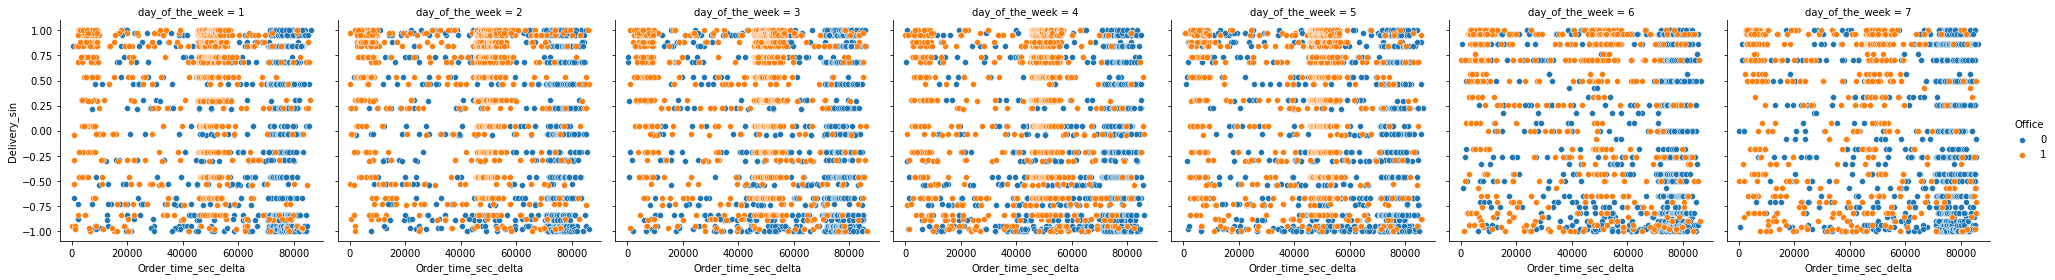

In [39]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', height=4)
plots.map(sns.scatterplot, 'Order_time_sec_delta', 'Delivery_sin', palette='Spectral')
plots.add_legend()

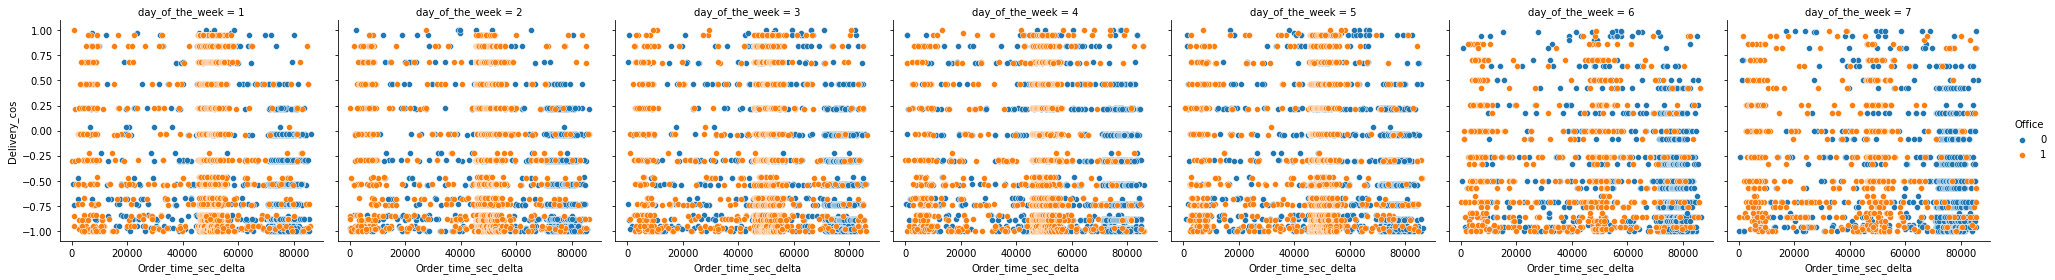

In [40]:
plots = sns.FacetGrid(df_train, col='day_of_the_week', hue='Office', height=4)
plots.map(sns.scatterplot, 'Order_time_sec_delta', 'Delivery_cos', palette='Spectral')
plots.add_legend()

Sin и Cos для Delivery_time только перемешивают данные, не группируют их

In [41]:
df_train['composition'] = df_train['Order_time_sec_delta'] * df_train['Delivery_time_Rain_Weekend']
df_test['composition'] = df_test['Order_time_sec_delta'] * df_test['Delivery_time_Rain_Weekend']

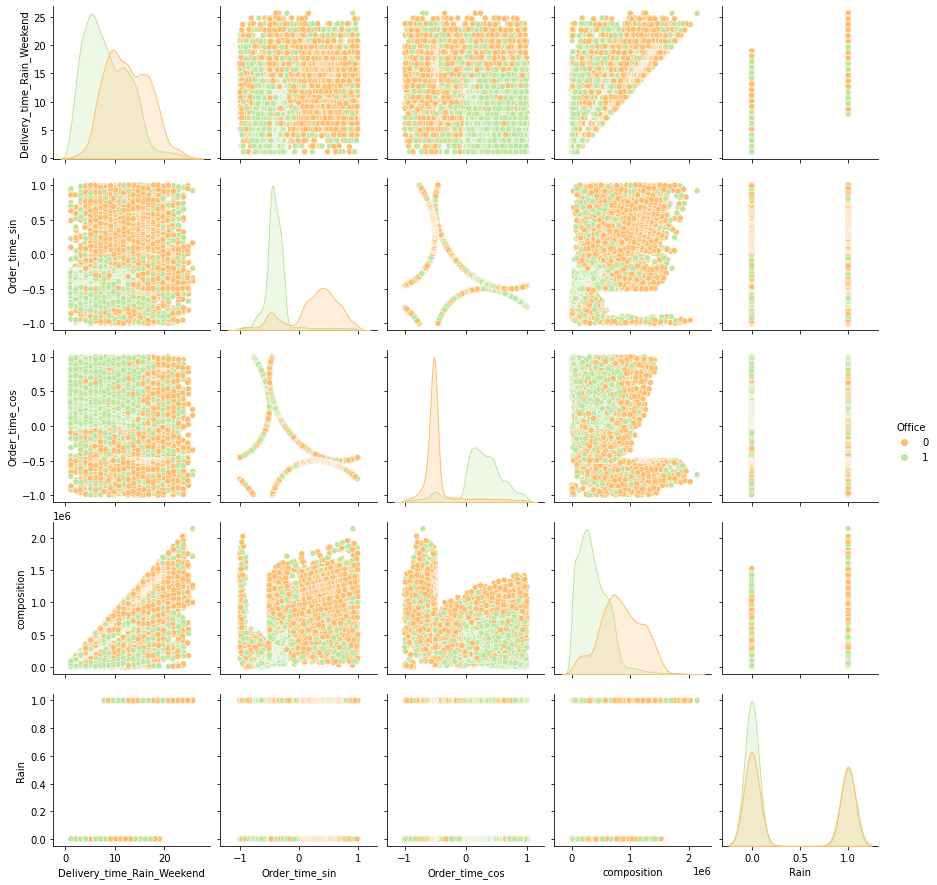

In [42]:
sns.pairplot(df_train[['Office', 'Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos', 'composition', 'Rain']], hue="Office", palette='Spectral')

Произведение параметров также не является информативным признаком

----

### Логистическая регрессия

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def log_reg(y, X):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
  sc = StandardScaler()
  sc.fit(X_train)
  X_train_std = sc.transform(X_train)
  X_test_std = sc.transform(X_test)
  lr = LogisticRegression(random_state=21)
  lr.fit(X_train_std, y_train)
  y_pred = lr.predict(X_test_std)
  print(classification_report(y_test, y_pred))
  return sc, lr

def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = [], pal = 'Set2'):
  X_std = sc.transform(df[attribute_name])
  new_col_name = []
  for i, col_name in enumerate(attribute_name):
    s = col_name + '_std_' + name
    df[s] = X_std[:,i]
    new_col_name.append(s)
  y_pred = 'y_pred_' + name
  Correct = 'Correct_' + name
  df[y_pred] = lr.predict(X_std)
  df[Correct] = df.Office == df[y_pred]
  print(classification_report(df.Office, df[y_pred]))
  # sns.pairplot(df[[Correct] + new_col_name], hue = Correct, height=round(12/len(new_col_name), 1), palette=pal)
  for k in range(len(add_schedule)):
    i,j = add_schedule[k]
    i = i+'_std_'+name
    j = j+'_std_'+name
    # sns.jointplot(x=df['Order_time_sec_delta'], y=df['Delivery_time'], hue=df[Correct], palette=pal)
  return df

- Результаты на контрольной выборке обучающего набора:

In [ ]:
y = df_train['Office']
X = df_train[['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos']]
sc_1, lr_1 = log_reg(y, X)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2332
           1       0.90      0.91      0.91      2866

    accuracy                           0.89      5198
   macro avg       0.89      0.89      0.89      5198
weighted avg       0.89      0.89      0.89      5198



- Результаты на полном обучающем наборе:

In [ ]:
y = 'Office'
x = ['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos']
df_train = Processing_results(sc_1, lr_1, df_train, y, x, '1')

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      9389
           1       0.90      0.91      0.90     11402

    accuracy                           0.89     20791
   macro avg       0.89      0.89      0.89     20791
weighted avg       0.89      0.89      0.89     20791



- Результаты на тестовом наборе:

In [ ]:
y = 'Office'
x = ['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos']
df_test = Processing_results(sc_1, lr_1, df_test, y, x, '1')

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2767
           1       0.86      0.89      0.88      2706

    accuracy                           0.88      5473
   macro avg       0.88      0.88      0.88      5473
weighted avg       0.88      0.88      0.88      5473



In [ ]:
df_train.describe()

----

### Дерево решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from IPython.core.display import Image, display
from sklearn.tree import export_graphviz

def decis_tree(y, X):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
  sc = StandardScaler()
  sc.fit(X_train)
  X_train_std = sc.transform(X_train)
  X_test_std = sc.transform(X_test)
  tree = DecisionTreeClassifier(random_state=21,max_depth=3)
  tree.fit(X_train_std, y_train)
  y_pred = tree.predict(X_test_std)
  print(classification_report(y_test, y_pred))
  return sc, tree

In [ ]:
y = df_train['Office']
X = df_train[['Delivery_time_Rain_Weekend', 'Order_time_sin_delta2', 'Order_time_cos']]
sc_2, lr_2 = decis_tree(y, X)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2332
           1       0.91      0.91      0.91      2866

    accuracy                           0.90      5198
   macro avg       0.90      0.90      0.90      5198
weighted avg       0.90      0.90      0.90      5198



In [ ]:
y = 'Office'
x = ['Delivery_time_Rain_Weekend', 'Order_time_sin_delta2', 'Order_time_cos']
df_train = Processing_results(sc_2, lr_2, df_train, y, x, '2')

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      9389
           1       0.91      0.91      0.91     11402

    accuracy                           0.90     20791
   macro avg       0.90      0.90      0.90     20791
weighted avg       0.90      0.90      0.90     20791



In [ ]:
y = 'Office'
x = ['Delivery_time_Rain_Weekend', 'Order_time_sin_delta2', 'Order_time_cos']
df_test = Processing_results(sc_2, lr_2, df_test, y, x, '2')

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2767
           1       0.90      0.89      0.89      2706

    accuracy                           0.90      5473
   macro avg       0.90      0.90      0.90      5473
weighted avg       0.90      0.90      0.90      5473



In [ ]:
df_train.describe()

Delivery_time        Office          Rain  day_of_the_week  \
count   20791.000000  20791.000000  20791.000000     20791.000000   
mean        8.283440      0.548410      0.398730         3.680872   
std         3.372459      0.497663      0.489649         1.834987   
min         2.000000      0.000000      0.000000         1.000000   
25%         6.000000      0.000000      0.000000         2.000000   
50%         8.000000      1.000000      0.000000         4.000000   
75%        10.000000      1.000000      1.000000         5.000000   
max        19.000000      1.000000      1.000000         7.000000   

       Order_time_sec  Order_year   Order_month     Order_day    Order_hour  \
count    20791.000000     20791.0  20791.000000  20791.000000  20791.000000   
mean     51790.927613      2020.0      9.510894     15.852003     13.885624   
std      19511.018745         0.0      0.499893      9.018616      5.413014   
min          6.000000      2020.0      9.000000      1.000000      0.000000   
25%      41833.500000      2020.0      9.000000      8.000000     11.000000   
50%      46638.000000      2020.0     10.000000     16.000000     12.000000   
75%      69497.500000      2020.0     10.000000     24.000000     19.000000   
max      86393.000000      2020.0     10.000000     31.000000     23.000000   

       Order_week_num_year  ...  Order_time_cos_delta2   composition  \
count         20791.000000  ...           20791.000000  2.079100e+04   
mean             40.071137  ...              -0.357628  5.841424e+05   
std               2.534360  ...               0.537589  3.864742e+05   
min              36.000000  ...              -1.498049  2.640000e+02   
25%              38.000000  ...              -0.913363  2.648373e+05   
50%              40.000000  ...              -0.403554  5.378740e+05   
75%              42.000000  ...               0.059234  8.225295e+05   
max              44.000000  ...               0.999937  2.140368e+06   

       Delivery_time_Rain_Weekend_std_1  Order_time_sin_std_1  \
count                      20791.000000          20791.000000   
mean                          -0.000999              0.002658   
std                            1.001404              0.998283   
min                           -1.874095             -1.945594   
25%                           -0.846118             -0.771632   
50%                           -0.052608             -0.459529   
75%                            0.735178              0.913721   
max                            3.173450              2.348641   

       Order_time_cos_std_1      y_pred_1  Delivery_time_Rain_Weekend_std_2  \
count          20791.000000  20791.000000                      20791.000000   
mean               0.002447      0.555769                         -0.000999   
std                0.998171      0.496892                          1.001404   
min               -1.928954      0.000000                         -1.874095   
25%               -0.931661      0.000000                         -0.846118   
50%                0.192298      1.000000                         -0.052608   
75%                0.816821      1.000000                          0.735178   
max                2.169349      1.000000                          3.173450   

       Order_time_sin_delta2_std_2  Order_time_cos_std_2     y_pred_2  
count                 20791.000000          20791.000000  20791.00000  
mean                      0.001237              0.002447      0.54514  
std                       0.999177              0.998171      0.49797  
min                      -2.306776             -1.928954      0.00000  
25%                      -0.797612             -0.931661      0.00000  
50%                      -0.161219              0.192298      1.00000  
75%                       0.767218              0.816821      1.00000  
max                       2.469639              2.169349      1.00000  

[8 rows x 29 columns]

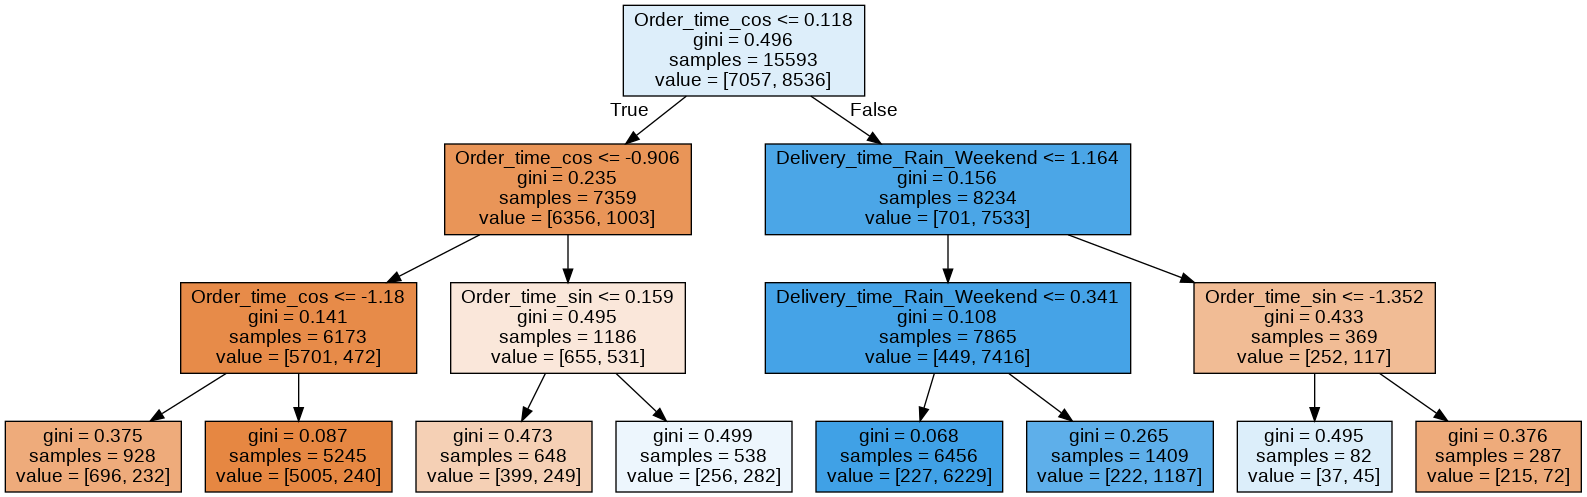

In [ ]:
export_graphviz(lr_2, feature_names=['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos'] , out_file='/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/tree.dot', filled=True)
!dot -Tpng '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/tree.dot' -o '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/tree.png'
display(Image('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/tree.png', unconfined=True))

----

### Метод ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def k_neib(y, X):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
  sc = StandardScaler()
  sc.fit(X_train)
  X_train_std = sc.transform(X_train)
  X_test_std = sc.transform(X_test)
  knn = KNeighborsClassifier(n_neighbors=7)
  knn.fit(X_train_std, y_train)
  y_pred = knn.predict(X_test_std)
  print(classification_report(y_test, y_pred))
  return sc, knn

In [ ]:
y = df_train['Office']
X = df_train[['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos']]
sc_3, lr_3 = k_neib(y, X)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2332
           1       0.92      0.90      0.91      2866

    accuracy                           0.90      5198
   macro avg       0.90      0.90      0.90      5198
weighted avg       0.90      0.90      0.90      5198



In [ ]:
y = 'Office'
x = ['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos']
df_train = Processing_results(sc_3, lr_3, df_train, y, x, '3')

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      9389
           1       0.93      0.90      0.92     11402

    accuracy                           0.91     20791
   macro avg       0.91      0.91      0.91     20791
weighted avg       0.91      0.91      0.91     20791



In [ ]:
y = 'Office'
x = ['Delivery_time_Rain_Weekend', 'Order_time_sin', 'Order_time_cos']
df_test = Processing_results(sc_3, lr_3, df_test, y, x, '3')

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2767
           1       0.89      0.88      0.89      2706

    accuracy                           0.89      5473
   macro avg       0.89      0.89      0.89      5473
weighted avg       0.89      0.89      0.89      5473

